## Exercise: Getting started with `acados` in `Python`
Authors: Jonathan Frey, Andrea Ghezzi, Moritz Diehl

### Important Resources:
- https://docs.acados.org/
- Installation guide https://docs.acados.org/installation/
- `Python` Interface: Installation and documentation https://docs.acados.org/python_interface/
    - Installation instructions https://docs.acados.org/installation
- `acados` problem formulation PDF: https://github.com/acados/acados/blob/master/docs/problem_formulation/problem_formulation_ocp_mex.pdf
- `acados` forum https://discourse.acados.org


### Exercise
We consider the nonlinear dynamical system given by a pendulum on a cart illustrated in the Figure below.
The state is given by $x = [p, \theta, v, \omega]^\top$ with cart position $p$, cart velocity $s$, angle of the pendulum $\theta$ and angular velocity $\omega$.
The control input is the horizontal force $F$ acting on the cart.
The ODE describing the system behavior is given by
\begin{align}
    \dot{x} = \begin{pmatrix}
    v \\
    \omega \\
    \dfrac{-m l \sin{(\theta)} \omega^2 + m g \cos{(\theta)} \sin{(\theta)}+F}{D} \\
    \dfrac{-m l \cos{(\theta)} \sin{(\theta)} \omega^2 + F \cos{(\theta)}+(M+m) g \sin{(\theta)}}{l D}
    \end{pmatrix}
    \text{with} \quad D = M + m - m\cos{(\theta)}^2
\end{align}

<img src="imgs/cartpole_schematic.png" alt="350" width="350"/>


#### Task overview
We aim to stabilize the pendulum in the upward position (unstable equilibrium point) using nonlinear model predictive control.

1. Fill out the function that exports the dynamic model of the pendulum
2. Run the open-loop simulation and plot the figure. If the dynamic is correct you should be able to stabilize the pendulum. **This step is useful to make you confortable we `acados` syntax**
3. Implement a closed-loop control of the system.
4. Modify the pendulum model to make the mass $M$ of the pendulum a parameter. Vary the mass if the cart only for the integrator by 20% and run again the closed-loop simulation. **The idea is to show the effect of model-plant mismatch**

In [1]:
import numpy as np
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver, AcadosSimSolver
import numpy as np
import scipy.linalg as scipylinalg
from utils import plot_pendulum

**Task 1**: Define a function that export the dynamic model of the system as an AcadosModel class.

In [2]:
from casadi import SX, vertcat, sin, cos

def export_pendulum_ode_model() -> AcadosModel:

    model_name = 'pendulum_ode'
    # constants
    M = 1. # mass of the cart [kg]
    m = 0.1 # mass of the ball [kg]
    g = 9.81 # gravity constant [m/s^2]
    l = 0.8 # length of the rod [m]

    # set up states & controls
    p = SX.sym('p')
    theta = SX.sym('theta')
    v = SX.sym('v')
    omega = SX.sym('omega')

    x = vertcat(p, theta, v, omega)

    F = SX.sym('F')
    u = vertcat(F)

    # xdot
    p_dot = SX.sym('p_dot')
    theta_dot = SX.sym('theta_dot')
    v_dot = SX.sym('v_dot')
    omega_dot = SX.sym('omega_dot')

    xdot = vertcat(p_dot, theta_dot, v_dot, omega_dot)

    # algebraic variables
    # z = None

    # parameters
    param = []

    # dynamics
    cos_theta = cos(theta)
    sin_theta = sin(theta)
    denominator = M + m - m*cos_theta*cos_theta
    f_expl = vertcat(v,
                     omega,
                     (-m*l*sin_theta*omega*omega + m*g*cos_theta*sin_theta+F)/denominator,
                     (-m*l*cos_theta*sin_theta*omega*omega + F*cos_theta+(M+m)*g*sin_theta)/(l*denominator)
                     )

    f_impl = xdot - f_expl

    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    # model.z = z
    model.p = param
    model.name = model_name

    return model

**Task 2**: Now, you only have to run the next three cells and if you did everything right, the OCP solution should be a stabilizing trajectory.

Pay attention to the cost formulation with the nonlinear least square module. You can checkout the syntax in Section 3.4 of https://github.com/acados/acados/blob/master/docs/problem_formulation/problem_formulation_ocp_mex.pdf

In [3]:
# Setting the initial condition and the parameter of the simulation

X0 = np.array([0.0, np.pi/6, 0.0, 0.0])
N_horizon = 50
T_horizon = 2.0
Fmax = 80

In [4]:
# create ocp object to formulate the OCP
ocp = AcadosOcp()

# set model
model = export_pendulum_ode_model()
ocp.model = model

# set dimensions
ocp.dims.N = N_horizon
nx = ocp.model.x.size()[0]
nu = ocp.model.u.size()[0]

# set cost
Q_mat = 2*np.diag([1e3, 1e3, 1e-2, 1e-2])
R_mat = 2*np.diag([1e-1])

# We use the NONLINEAR_LS cost type and GAUSS_NEWTON Hessian approximation - One can also use the external cost module to specify generic cost.
ocp.cost.cost_type = 'NONLINEAR_LS'
ocp.cost.cost_type_e = 'NONLINEAR_LS'
ocp.cost.W = scipylinalg.block_diag(Q_mat, R_mat)
ocp.cost.W_e = Q_mat

ocp.model.cost_y_expr = vertcat(model.x, model.u)
ocp.model.cost_y_expr_e = model.x
ocp.cost.yref = np.zeros((nx+nu, ))
ocp.cost.yref_e = np.zeros((nx, ))

# set constraints
ocp.constraints.lbu = np.array([-Fmax])
ocp.constraints.ubu = np.array([+Fmax])
ocp.constraints.idxbu = np.array([0])

ocp.constraints.x0 = X0

# set options
ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES, PARTIAL_CONDENSING_HPIPM
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON' # 'GAUSS_NEWTON', 'EXACT'
ocp.solver_options.integrator_type = 'IRK'
# ocp.solver_options.print_level = 1
ocp.solver_options.nlp_solver_type = 'SQP' # SQP_RTI, SQP
ocp.solver_options.nlp_solver_max_iter = 400
# ocp.solver_options.levenberg_marquardt = 1e-4

# set prediction horizon
ocp.solver_options.tf = T_horizon

rm -f libacados_ocp_solver_pendulum_ode.so
rm -f pendulum_ode_cost/pendulum_ode_cost_y_0_fun.o pendulum_ode_cost/pendulum_ode_cost_y_0_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_0_hess.o pendulum_ode_cost/pendulum_ode_cost_y_fun.o pendulum_ode_cost/pendulum_ode_cost_y_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_hess.o pendulum_ode_cost/pendulum_ode_cost_y_e_fun.o pendulum_ode_cost/pendulum_ode_cost_y_e_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_e_hess.o acados_solver_pendulum_ode.o
cc -fPIC -std=c99   -O2 -I/app/acados/include -I/app/acados/include/acados -I/app/acados/include/blasfeo/include -I/app/acados/include/hpipm/include  -c -o pendulum_ode_cost/pendulum_ode_cost_y_0_fun.o pendulum_ode_cost/pendulum_ode_cost_y_0_fun.c
cc -fPIC -std=c99   -O2 -I/app/acados/include -I/app/acados/include/acados -I/app/acados/include/blasfeo/include -I/app/acados/include/hpipm/include  -c -o pendulum_ode_cost/pendulum_ode_cost_y_0_fun_jac_ut_xt.o pendulum_ode_cost/pen

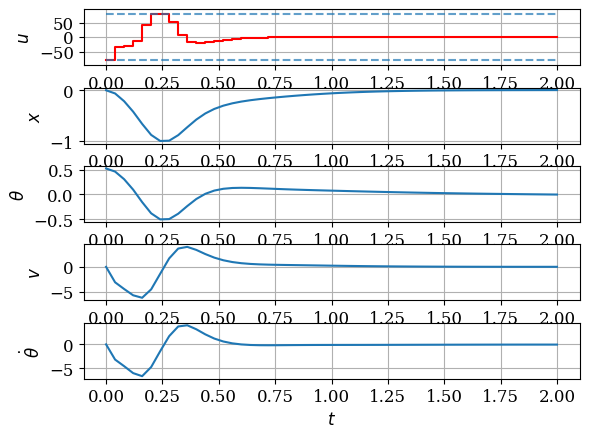

In [5]:
# Create OCP solver
acados_ocp_solver = AcadosOcpSolver(ocp)

# Initialize quantities
nx = ocp.model.x.size()[0]
nu = ocp.model.u.size()[0]
simX = np.ndarray((N_horizon+1, nx))
simU = np.ndarray((N_horizon, nu))

# Solve OCP by calling the method .solve()
status = acados_ocp_solver.solve()
acados_ocp_solver.print_statistics()  #NOTE: encapsulates: stat = acados_ocp_solver.get_stats("statistics")

if status != 0:
    raise Exception(f'acados returned status {status}.')

# get solution
for i in range(N_horizon):
    simX[i,:] = acados_ocp_solver.get(i, "x")
    simU[i,:] = acados_ocp_solver.get(i, "u")
simX[N_horizon,:] = acados_ocp_solver.get(N_horizon, "x")

plot_pendulum(np.linspace(0, T_horizon, N_horizon+1), Fmax, simU, simX, latexify=False)

----
**Task 3**: Let's implement the closed loop control of our cart pole system.
1. We need an acados ocp solver, to solve the ocp, and an acados integrator, to simulate the system in closed-loop
2. Remember: in closed-loop simulation we need to update the new initial state of the OCP -> let's use the `solve_for_x0` method
3. Remember: we apply to the system only the fist optimal control input $u_{0|t}^\star$ -> let's use the `simulate` method


cc -fPIC -std=c99   -O2 -I/app/acados/include -I/app/acados/include/acados -I/app/acados/include/blasfeo/include -I/app/acados/include/hpipm/include  -c -o acados_sim_solver_pendulum_ode.o acados_sim_solver_pendulum_ode.c
cc -shared acados_sim_solver_pendulum_ode.o pendulum_ode_model/pendulum_ode_impl_dae_fun.o pendulum_ode_model/pendulum_ode_impl_dae_fun_jac_x_xdot_z.o pendulum_ode_model/pendulum_ode_impl_dae_jac_x_xdot_u_z.o -o libacados_sim_solver_pendulum_ode.so -L/app/acados/lib -lacados -lhpipm -lblasfeo -lm
acados was compiled without OpenMP.


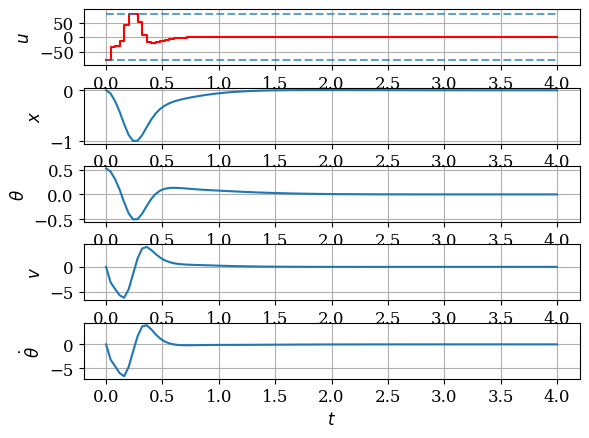

In [6]:
# create an integrator with the same settings as used in the OCP solver.
acados_integrator = AcadosSimSolver(ocp)

Nsim = 100
simX = np.ndarray((Nsim+1, nx))
simU = np.ndarray((Nsim, nu))

simX[0,:] = X0

# closed loop
for i in range(Nsim):

    # initialize solver
    if i == 0:
        for stage in range(N_horizon+1):
            acados_ocp_solver.set(stage, 'x', X0)

    # solve ocp
    simU[i,:] = acados_ocp_solver.solve_for_x0(x0_bar=simX[i,:])

    # simulate system
    simX[i+1,:] = acados_integrator.simulate(x=simX[i,:], u=simU[i,:])

# plot results
plot_pendulum(np.linspace(0, T_horizon/N_horizon*Nsim, Nsim+1), Fmax, simU, simX)

---
**Task 4: model-plant mismatch**
1. Copy-paste the cell with the model and edit it such that $M$ is a parameter of the OCP. In this way you can easily vary it.
2. Vary the mass by a 20% and run again the closed loop simulation. What do you observe?

In [7]:
# This cell is needed to fully remove the objects and generated libraries in python notebooks
acados_ocp_solver = None
acados_integrator = None

In [8]:
# Setting the initial condition and the parameter of the simulation

X0 = np.array([0.0, np.pi/6, 0.0, 0.0])
N_horizon = 50
T_horizon = 2.0
Fmax = 80

In [9]:
from casadi import SX, vertcat, sin, cos

def export_parametric_pendulum_ode_model() -> AcadosModel:

    model_name = 'pendulum_ode'
    # constants
    M = SX.sym('M') # mass of the cart [kg]
    m = 0.1 # mass of the ball [kg]
    g = 9.81 # gravity constant [m/s^2]
    l = 0.8 # length of the rod [m]

    # set up states & controls
    p = SX.sym('p')
    theta = SX.sym('theta')
    v = SX.sym('v')
    omega = SX.sym('omega')

    x = vertcat(p, theta, v, omega)

    F = SX.sym('F')
    u = vertcat(F)

    # xdot
    p_dot = SX.sym('p_dot')
    theta_dot = SX.sym('theta_dot')
    v_dot = SX.sym('v_dot')
    omega_dot = SX.sym('omega_dot')

    xdot = vertcat(p_dot, theta_dot, v_dot, omega_dot)

    # algebraic variables
    # z = None

    # parameters
    param = M

    # dynamics
    cos_theta = cos(theta)
    sin_theta = sin(theta)
    denominator = M + m - m*cos_theta*cos_theta
    f_expl = vertcat(v,
                     omega,
                     (-m*l*sin_theta*omega*omega + m*g*cos_theta*sin_theta+F)/denominator,
                     (-m*l*cos_theta*sin_theta*omega*omega + F*cos_theta+(M+m)*g*sin_theta)/(l*denominator)
                     )

    f_impl = xdot - f_expl

    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    # model.z = z
    model.p = param
    model.name = model_name

    return model

In [10]:
# create ocp object to formulate the OCP
ocp = AcadosOcp()

# set model
model = export_parametric_pendulum_ode_model()
ocp.parameter_values = np.array([1.0])
ocp.model = model

# set dimensions
ocp.dims.N = N_horizon
nu = ocp.model.u.size()[0]
nx = ocp.model.x.size()[0]

# set cost
Q_mat = 2*np.diag([1e3, 1e3, 1e-2, 1e-2])
R_mat = 2*np.diag([1e-1])

# We use the NONLINEAR_LS cost type and GAUSS_NEWTON Hessian approximation - One can also use the external cost module to specify generic cost.
ocp.cost.cost_type = 'NONLINEAR_LS'
ocp.cost.cost_type_e = 'NONLINEAR_LS'
ocp.cost.W = scipylinalg.block_diag(Q_mat, R_mat)
ocp.cost.W_e = Q_mat

ocp.model.cost_y_expr = vertcat(model.x, model.u)
ocp.model.cost_y_expr_e = model.x
ocp.cost.yref  = np.zeros((nx+nu, ))
ocp.cost.yref_e = np.zeros((nx, ))

# set constraints
ocp.constraints.lbu = np.array([-Fmax])
ocp.constraints.ubu = np.array([+Fmax])
ocp.constraints.idxbu = np.array([0])

ocp.constraints.x0 = X0

# set options
ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES
# PARTIAL_CONDENSING_HPIPM, FULL_CONDENSING_QPOASES, FULL_CONDENSING_HPIPM,
# PARTIAL_CONDENSING_QPDUNES, PARTIAL_CONDENSING_OSQP, FULL_CONDENSING_DAQP
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON' # 'GAUSS_NEWTON', 'EXACT'
ocp.solver_options.integrator_type = 'IRK'
# ocp.solver_options.print_level = 1
ocp.solver_options.nlp_solver_type = 'SQP' # SQP_RTI, SQP
ocp.solver_options.nlp_solver_max_iter = 400
# ocp.solver_options.levenberg_marquardt = 1e-4

# set prediction horizon
ocp.solver_options.tf = T_horizon

In [11]:
acados_ocp_solver = AcadosOcpSolver(ocp)
# create an integrator with the same settings as used in the OCP solver.
acados_integrator = AcadosSimSolver(ocp)

rm -f libacados_ocp_solver_pendulum_ode.so
rm -f pendulum_ode_cost/pendulum_ode_cost_y_0_fun.o pendulum_ode_cost/pendulum_ode_cost_y_0_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_0_hess.o pendulum_ode_cost/pendulum_ode_cost_y_fun.o pendulum_ode_cost/pendulum_ode_cost_y_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_hess.o pendulum_ode_cost/pendulum_ode_cost_y_e_fun.o pendulum_ode_cost/pendulum_ode_cost_y_e_fun_jac_ut_xt.o pendulum_ode_cost/pendulum_ode_cost_y_e_hess.o acados_solver_pendulum_ode.o
cc -fPIC -std=c99   -O2 -I/app/acados/include -I/app/acados/include/acados -I/app/acados/include/blasfeo/include -I/app/acados/include/hpipm/include  -c -o pendulum_ode_cost/pendulum_ode_cost_y_0_fun.o pendulum_ode_cost/pendulum_ode_cost_y_0_fun.c
cc -fPIC -std=c99   -O2 -I/app/acados/include -I/app/acados/include/acados -I/app/acados/include/blasfeo/include -I/app/acados/include/hpipm/include  -c -o pendulum_ode_cost/pendulum_ode_cost_y_0_fun_jac_ut_xt.o pendulum_ode_cost/pen

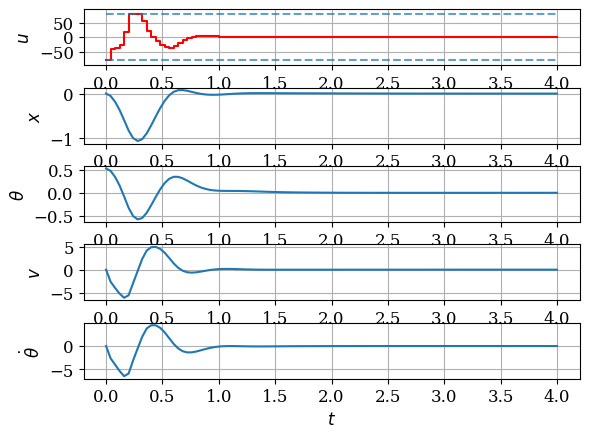

In [12]:
# Set the parameter value
acados_integrator.set('p', np.array([1.2]))

# prepare closed loop simulation
Nsim = 100

nx = ocp.model.x.size()[0]
nu = ocp.model.u.size()[0]
simX = np.ndarray((Nsim+1, nx))
simU = np.ndarray((Nsim, nu))

simX[0,:] = X0

# closed loop
for i in range(Nsim):

    # initialize solver
    if i == 0:
        for stage in range(N_horizon+1):
            acados_ocp_solver.set(stage, 'x', simX[i,:])

    # solve ocp
    simU[i,:] = acados_ocp_solver.solve_for_x0(x0_bar=simX[i,:])

    # simulate system
    simX[i+1,:] = acados_integrator.simulate(x=simX[i,:], u=simU[i,:])

# plot results
plot_pendulum(np.linspace(0, T_horizon/N_horizon*Nsim, Nsim+1), Fmax, simU, simX)